In [12]:
import pandas as pd
import numpy as np
import logging
from typing import List, Dict, Tuple

class DataBiasDetection:
    def __init__(self, data: pd.DataFrame):
        """Initialize with dataset."""
        self.data = data
        self.bias_report = {}

    def data_slicing(self, slice_cols: List[str]) -> Dict[str, pd.DataFrame]:
        """Slice data based on unique values in specified columns."""
        sliced_data = {}
        for col in slice_cols:
            unique_vals = self.data[col].unique()
            for val in unique_vals:
                slice_name = f"{col}_{val}"
                sliced_data[slice_name] = self.data[self.data[col] == val]
                logging.info(f"Data slice created: {slice_name} with {len(sliced_data[slice_name])} rows.")
        return sliced_data

    def calculate_statistics(self, sliced_data: Dict[str, pd.DataFrame], feature_col: str) -> Dict[str, float]:
        """Calculate mean statistics for each data slice."""
        slice_statistics = {}
        for slice_name, df_slice in sliced_data.items():
            mean_value = df_slice[feature_col].mean()
            slice_statistics[slice_name] = mean_value
            logging.info(f"Mean {feature_col} for slice {slice_name}: {mean_value:.2f}")
        return slice_statistics

    def detect_bias(self, slice_statistics: Dict[str, float], threshold_ratio: float = 0.2) -> List[Tuple[str, float]]:
        """Detect bias by identifying slices with significant mean deviation.
        Returns the biased slices and their mean values if bias is detected.
        """
        overall_mean = np.mean(list(slice_statistics.values()))
        biased_slices = [
            (slice_name, mean_value) for slice_name, mean_value in slice_statistics.items()
            if abs(mean_value - overall_mean) > threshold_ratio * overall_mean
        ]
        
        # Log bias detection
        if biased_slices:
            logging.warning(f"Bias detected in slices: {[slice[0] for slice in biased_slices]}")
            self.bias_report['biased_slices'] = biased_slices
        else:
            logging.info("No significant bias detected.")
            self.bias_report['biased_slices'] = []

        return biased_slices

    def document_bias_report(self) -> None:
        """Log and document bias detection results."""
        logging.info("Bias Report:")
        for key, value in self.bias_report.items():
            logging.info(f"{key}: {value}")

    def mitigate_bias_resample_with_imputation(self, slice_cols: List[str], date_col: str, feature_cols: List[str]) -> pd.DataFrame:
        """Mitigate bias by re-sampling underrepresented slices with rolling average imputation for missing dates."""
        max_count = max(len(self.data[self.data[col] == val])
                        for col in slice_cols for val in self.data[col].unique())
        
        print(self.data.columns)
        
        resampled_data = pd.DataFrame()
        date_range = pd.date_range(start=self.data[date_col].min(), end=self.data[date_col].max(), freq='D')

        for col in slice_cols:
            for val in self.data[col].unique():
                # Create a subset for each unique value in the slice column
                subset = self.data[self.data[col] == val].set_index(date_col)
                
                # Reindex to include all dates in the range and fill missing feature columns using rolling average

                subset = subset.reindex(date_range).sort_index()
                subset[slice_cols] = val  # Ensure the slice column retains its value
                for feature in feature_cols:
                    subset[feature] = subset[feature].fillna(subset[feature].rolling(window=3, min_periods=1).mean())

                # Ensure we have max_count rows by resampling with replacement if needed
                resampled_subset = subset.sample(n=max_count, replace=True, random_state=42)
                
                # Reset index and append to resampled data

                resampled_data = pd.concat([resampled_data, resampled_subset.reset_index()], axis=0)
                logging.info(f"Resampled data slice {col}_{val} to {max_count} rows with imputation.")

        resampled_data = resampled_data.rename(columns={'index': date_col})
        return resampled_data.reset_index(drop=True)

    

In [13]:
import pandas as pd
import logging

# Set up logging to see warnings and info
logging.basicConfig(level=logging.INFO)

# Load the dataset from a local CSV file
data = pd.read_csv('/Users/akm/Desktop/mlops-project/preprocessed_data.csv')

# Instantiate the detector with the loaded data
detector = DataBiasDetection(data)

# Define columns to slice the data and the metric columns for bias detection
slice_columns = ['zone']
exclude_columns = ['datetime'] + slice_columns 
feature_columns = data.columns.difference(exclude_columns)

sliced_data = None
slice_statistics = None
biased_slices = None
resampled_data = None

# Perform bias detection for each metric column
for feature_column in feature_columns:
    print(f"\nDetecting bias for metric column: {feature_column}")
    
    # Slice the data based on the slice columns
    sliced_data = detector.data_slicing(slice_cols=slice_columns)
    
    # Calculate statistics (mean) for each slice based on the metric column
    slice_statistics = detector.calculate_statistics(sliced_data, feature_col=feature_column)
    
    # Detect bias in the slices
    biased_slices = detector.detect_bias(slice_statistics)
    
    # Check and print results
    if biased_slices:
        print("Bias detected in slices:", biased_slices)
    else:
        print("No significant bias detected.")
    
    resampled_data = detector.mitigate_bias_resample_with_imputation(slice_cols=slice_columns, date_col = 'datetime', feature_cols = feature_columns)
    # Document the bias report for this metric column
    detector.document_bias_report()


INFO:root:Data slice created: zone_1 with 30634 rows.
INFO:root:Data slice created: zone_7 with 30634 rows.
INFO:root:Data slice created: zone_3 with 30633 rows.
INFO:root:Data slice created: zone_4 with 30633 rows.
INFO:root:Data slice created: zone_5 with 30633 rows.
INFO:root:Data slice created: zone_2 with 30633 rows.
INFO:root:Data slice created: zone_6 with 30633 rows.
INFO:root:Data slice created: zone_0 with 30633 rows.
INFO:root:Data slice created: zone_16 with 34979 rows.
INFO:root:Data slice created: zone_19 with 34979 rows.
INFO:root:Data slice created: zone_24 with 34979 rows.
INFO:root:Data slice created: zone_26 with 34979 rows.
INFO:root:Data slice created: zone_20 with 34979 rows.
INFO:root:Data slice created: zone_22 with 34979 rows.
INFO:root:Data slice created: zone_17 with 34979 rows.
INFO:root:Data slice created: zone_18 with 34979 rows.
INFO:root:Data slice created: zone_25 with 34979 rows.
INFO:root:Data slice created: zone_21 with 34979 rows.
INFO:root:Data sli


Detecting bias for metric column: FeelsLikeF
Bias detected in slices: [('zone_8', 0.7086940969340797), ('zone_14', 0.7441896180043099)]
Index(['Unnamed: 0', 'precipMM', 'weatherCode', 'visibility', 'HeatIndexF',
       'WindChillF', 'windspeedMiles', 'FeelsLikeF', 'tempF_rolling_mean',
       'windspeedMiles_rolling_mean', 'humidity_rolling_mean', 'value',
       'pressure', 'pressureInches', 'cloudcover', 'uvIndex', 'subba-name',
       'zone', 'tempF_rolling_std', 'windspeedMiles_rolling_std',
       'humidity_rolling_std', 'tempF_lag_2', 'windspeedMiles_lag_2',
       'humidity_lag_2', 'tempF_lag_4', 'windspeedMiles_lag_4',
       'humidity_lag_4', 'tempF_lag_6', 'windspeedMiles_lag_6',
       'humidity_lag_6', 'month_sin', 'month_cos'],
      dtype='object')


KeyError: 'datetime'

In [4]:
data.shape

(880291, 32)

In [5]:
resampled_data.shape

(944433, 32)

In [5]:
import pandas as pd

df = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess.csv')
df['subba-name'] = df['subba-name'].astype(str)
df['zone'] = df['zone'].astype(str)
df

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_84639/3886277396.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess.csv')


,datetime,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,...,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name,zone
0,2019-01-01 00:00:00,0.052731,0.861702,1.0,0.402878,0.457516,0.200,0.43750,0.422594,0.327044,...,0.462121,0.250,0.916667,0.416667,0.275,0.885417,0.75,0.933013,ISNE - New Hampshire,4002
1,2019-01-01 00:00:00,0.058380,0.861702,0.2,0.424460,0.477124,0.300,0.45625,0.422594,0.345912,...,0.484848,0.250,0.937500,0.446970,0.225,0.968750,0.75,0.933013,ISNE - Northeast Mass.,4008
2,2019-01-01 01:00:00,0.050847,0.861702,0.6,0.460432,0.522876,0.225,0.50000,0.426778,0.339623,...,0.477273,0.200,0.958333,0.462121,0.250,0.916667,0.75,0.933013,ISNE - Connecticut,4004
3,2019-01-01 01:00:00,0.064030,0.861702,0.6,0.467626,0.529412,0.275,0.50625,0.428173,0.345912,...,0.401515,0.275,0.833333,0.484848,0.250,0.937500,0.75,0.933013,ISNE - Rhode Island,4005
4,2019-01-01 01:00:00,0.054614,0.861702,0.9,0.402878,0.464052,0.200,0.44375,0.418410,0.345912,...,0.424242,0.200,0.958333,0.477273,0.200,0.958333,0.75,0.933013,ISNE - New Hampshire,4002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116266,2024-01-01 00:00:00,0.000000,0.000000,1.0,0.460432,0.516340,0.300,0.49375,0.520223,0.320755,...,0.613636,0.275,0.677083,0.530303,0.200,0.447917,0.75,0.933013,ERCO - Far West,FWES
1116267,2024-01-01 00:00:00,0.000000,0.010638,1.0,0.503597,0.581699,0.150,0.55625,0.517434,0.327044,...,0.545455,0.225,0.614583,0.545455,0.125,0.458333,0.75,0.933013,ERCO - East,EAST
1116268,2024-01-01 00:00:00,0.001883,0.223404,1.0,0.597122,0.679739,0.150,0.65000,0.520223,0.295597,...,0.583333,0.125,0.843750,0.613636,0.275,0.677083,0.75,0.933013,ERCO - Coast,COAS
1116269,2024-01-01 00:00:00,0.000000,0.000000,1.0,0.625899,0.705882,0.300,0.67500,0.541144,0.314465,...,0.454545,0.325,0.645833,0.545455,0.225,0.614583,0.75,0.933013,ERCO - South,SOUT


In [7]:
df.describe()

,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,humidity_rolling_mean,...,windspeedMiles_lag_2,humidity_lag_2,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos
count,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,...,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06,1.116271e+06
mean,2.569103e-03,8.996441e-02,9.147898e-01,5.518041e-01,6.157885e-01,2.064490e-01,5.938949e-01,5.597729e-01,2.864638e-01,6.468494e-01,...,2.064489e-01,6.738261e-01,5.736832e-01,2.064490e-01,6.738264e-01,5.736831e-01,2.064489e-01,6.738271e-01,4.782626e-01,5.004583e-01
std,1.181891e-02,2.121369e-01,2.111960e-01,1.490520e-01,1.464348e-01,1.084086e-01,1.464234e-01,1.594330e-01,1.313615e-01,1.903274e-01,...,1.084085e-01,2.068161e-01,1.480246e-01,1.084085e-01,2.068164e-01,1.480247e-01,1.084084e-01,2.068165e-01,3.518997e-01,3.545335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.000000e+00,4.316547e-01,5.032680e-01,1.250000e-01,4.812500e-01,4.323570e-01,1.886792e-01,5.150376e-01,...,1.250000e-01,5.312500e-01,4.545455e-01,1.250000e-01,5.312500e-01,4.545455e-01,1.250000e-01,5.312500e-01,6.698750e-02,6.698750e-02
50%,0.000000e+00,1.063830e-02,1.000000e+00,5.539568e-01,6.339869e-01,2.000000e-01,6.062500e-01,5.718271e-01,2.641509e-01,6.654135e-01,...,2.000000e-01,6.979167e-01,5.833333e-01,2.000000e-01,6.979167e-01,5.833333e-01,2.000000e-01,6.979167e-01,5.000000e-01,5.000000e-01
75%,0.000000e+00,3.191489e-02,1.000000e+00,6.834532e-01,7.320261e-01,2.750000e-01,7.125000e-01,6.820084e-01,3.710692e-01,7.969925e-01,...,2.750000e-01,8.437500e-01,6.893939e-01,2.750000e-01,8.437500e-01,6.893939e-01,2.750000e-01,8.437500e-01,7.500000e-01,9.330125e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
df.columns



Index(['datetime', 'precipMM', 'weatherCode', 'visibility', 'HeatIndexF',
       'WindChillF', 'windspeedMiles', 'FeelsLikeF', 'tempF_rolling_mean',
       'windspeedMiles_rolling_mean', 'humidity_rolling_mean', 'value',
       'pressure', 'pressureInches', 'cloudcover', 'uvIndex',
       'tempF_rolling_std', 'windspeedMiles_rolling_std',
       'humidity_rolling_std', 'tempF_lag_2', 'windspeedMiles_lag_2',
       'humidity_lag_2', 'tempF_lag_4', 'windspeedMiles_lag_4',
       'humidity_lag_4', 'tempF_lag_6', 'windspeedMiles_lag_6',
       'humidity_lag_6', 'month_sin', 'month_cos', 'subba-name', 'zone'],
      dtype='object')

In [8]:
df['zone'].value_counts()

zone
ZONG    43719
ZONH    43719
ZONJ    43719
ZONC    43719
ZONB    43719
ZONE    43719
ZONK    43719
ZONI    43719
ZOND    43719
ZONA    43719
ZONF    43719
FWES    40047
NCEN    40047
NRTH    40047
COAS    40047
SCEN    40047
SOUT    40047
WEST    40047
EAST    40047
4008    39374
4002    39374
4001    39373
4007    39373
4003    39373
4006    39373
4005    39373
4004    39373
Name: count, dtype: int64

In [13]:
df['subba-name'].value_counts()

subba-name
Hudson Valley - NYIS            43719
Millwood - NYIS                 43719
New York City - NYIS            43719
Central - NYIS                  43719
Genesee - NYIS                  43719
Mohawk Valley - NYIS            43719
Long Island - NYIS              43719
Dunwoodie - NYIS                43719
North - NYIS                    43719
West - NYIS                     43719
Capital - NYIS                  43719
ERCO - Far West                 40047
ERCO - North Central            40047
ERCO - North                    40047
ERCO - Coast                    40047
ERCO - South Central            40047
ERCO - South                    40047
ERCO - West                     40047
ERCO - East                     40047
ISNE - Northeast Mass.          39374
ISNE - New Hampshire            39374
ISNE - Maine                    39373
ISNE - Western/Central Mass.    39373
ISNE - Vermont                  39373
ISNE - Southeast Mass.          39373
ISNE - Rhode Island             39373
I

In [18]:
!pip install fairlearn

In [25]:
# Find records where both 'subba-name' and 'zone' are not null
records_with_both = df[(df['subba-name'].notnull()) & (df['zone'].notnull())]

In [26]:
records_with_both

,datetime,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,...,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name,zone
0,2019-01-01 00:00:00,0.052731,0.861702,1.0,0.402878,0.457516,0.200000,0.437500,0.422594,0.327044,...,0.462121,0.250000,0.916667,0.416667,0.275000,0.885417,0.750000,0.933013,15,1
1,2019-01-01 01:00:00,0.050847,0.861702,0.6,0.460432,0.522876,0.225000,0.500000,0.426778,0.339623,...,0.477273,0.200000,0.958333,0.462121,0.250000,0.916667,0.750000,0.933013,13,3
2,2019-01-01 02:00:00,0.050847,0.861702,0.8,0.410072,0.470588,0.200000,0.450000,0.415621,0.377358,...,0.462121,0.300000,0.947917,0.424242,0.200000,0.968750,0.750000,0.933013,15,1
3,2019-01-01 03:00:00,0.039548,0.861702,0.7,0.424460,0.470588,0.375000,0.450000,0.426778,0.440252,...,0.492424,0.275000,0.937500,0.492424,0.250000,0.947917,0.750000,0.933013,14,0
4,2019-01-01 04:00:00,0.011299,0.659574,0.8,0.417266,0.464052,0.350000,0.443750,0.450488,0.345912,...,0.469697,0.100000,0.958333,0.424242,0.350000,0.885417,0.750000,0.933013,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48917,2024-04-05 00:00:00,0.002933,0.771739,1.0,0.107527,0.075269,0.297297,0.071429,0.072340,0.458333,...,0.147727,0.351351,0.864583,0.113636,0.189189,0.895833,0.933013,0.250000,16,7
48918,2024-04-05 01:00:00,0.014663,0.815217,0.2,0.096774,0.064516,0.297297,0.061224,0.036170,0.319444,...,0.102273,0.270270,0.979167,0.090909,0.081081,0.937500,0.933013,0.250000,15,1
48919,2024-04-05 02:00:00,0.000000,0.771739,1.0,0.086022,0.096774,0.081081,0.091837,0.031915,0.215278,...,0.079545,0.270270,0.989583,0.159091,0.378378,0.989583,0.933013,0.250000,20,6
48920,2024-04-05 03:00:00,0.000000,0.000000,1.0,0.107527,0.075269,0.243243,0.071429,0.055319,0.333333,...,0.102273,0.189189,0.895833,0.102273,0.297297,0.968750,0.933013,0.250000,18,5


In [11]:
df[['zone', 'subba-name']].drop_duplicates().shape[0]

27

In [15]:
df_without_zone = df.drop(columns=['zone'])

In [16]:
df_without_zone

,datetime,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,...,humidity_lag_2,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name
0,2019-01-01 00:00:00,0.052731,0.861702,1.0,0.402878,0.457516,0.200,0.43750,0.422594,0.327044,...,0.958333,0.462121,0.250,0.916667,0.416667,0.275,0.885417,0.75,0.933013,ISNE - New Hampshire
1,2019-01-01 00:00:00,0.058380,0.861702,0.2,0.424460,0.477124,0.300,0.45625,0.422594,0.345912,...,0.833333,0.484848,0.250,0.937500,0.446970,0.225,0.968750,0.75,0.933013,ISNE - Northeast Mass.
2,2019-01-01 01:00:00,0.050847,0.861702,0.6,0.460432,0.522876,0.225,0.50000,0.426778,0.339623,...,0.958333,0.477273,0.200,0.958333,0.462121,0.250,0.916667,0.75,0.933013,ISNE - Connecticut
3,2019-01-01 01:00:00,0.064030,0.861702,0.6,0.467626,0.529412,0.275,0.50625,0.428173,0.345912,...,0.947917,0.401515,0.275,0.833333,0.484848,0.250,0.937500,0.75,0.933013,ISNE - Rhode Island
4,2019-01-01 01:00:00,0.054614,0.861702,0.9,0.402878,0.464052,0.200,0.44375,0.418410,0.345912,...,0.958333,0.424242,0.200,0.958333,0.477273,0.200,0.958333,0.75,0.933013,ISNE - New Hampshire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116266,2024-01-01 00:00:00,0.000000,0.000000,1.0,0.460432,0.516340,0.300,0.49375,0.520223,0.320755,...,0.843750,0.613636,0.275,0.677083,0.530303,0.200,0.447917,0.75,0.933013,ERCO - Far West
1116267,2024-01-01 00:00:00,0.000000,0.010638,1.0,0.503597,0.581699,0.150,0.55625,0.517434,0.327044,...,0.645833,0.545455,0.225,0.614583,0.545455,0.125,0.458333,0.75,0.933013,ERCO - East
1116268,2024-01-01 00:00:00,0.001883,0.223404,1.0,0.597122,0.679739,0.150,0.65000,0.520223,0.295597,...,0.447917,0.583333,0.125,0.843750,0.613636,0.275,0.677083,0.75,0.933013,ERCO - Coast
1116269,2024-01-01 00:00:00,0.000000,0.000000,1.0,0.625899,0.705882,0.300,0.67500,0.541144,0.314465,...,0.645833,0.454545,0.325,0.645833,0.545455,0.225,0.614583,0.75,0.933013,ERCO - South


In [20]:
# Re-import necessary libraries and re-create the data and logic after state reset
import pandas as pd
import numpy as np
from fairlearn.metrics import MetricFrame, selection_rate
from datetime import timedelta

# Sample data structure (mock data for demonstration purposes)
data = df

# Impute missing dates for each 'zone'
zones = data['zone'].unique()
min_date = data['datetime'].min()
max_date = data['datetime'].max()
full_date_range = pd.date_range(min_date, max_date, freq='H')

# imputed_data = pd.DataFrame()

# for zone in zones:
#     zone_data = data[data['zone'] == zone]
#     zone_data.set_index('datetime', inplace=True)
#     zone_data = zone_data.reindex(full_date_range, fill_value=np.nan)
#     zone_data['zone'] = zone
#     zone_data['subba-name'] = zone_data['subba-name'].fillna(method='ffill')  # Forward fill subba-name
#     zone_data['value'] = zone_data['value'].fillna(zone_data['value'].rolling(window=3, min_periods=1).mean())
#     zone_data.reset_index(inplace=True)
#     zone_data.rename(columns={'index': 'datetime'}, inplace=True)
#     imputed_data = pd.concat([imputed_data, zone_data])

# Perform bias detection using FairLearn's MetricFrame on 'subba-name'
metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=imputed_data['value'].notnull().astype(int),  # Considering non-null values as positive outcomes
    y_pred=imputed_data['value'].notnull().astype(int),
    sensitive_features=imputed_data['subba-name']
)

# Display metric frame results
import ace_tools as tools; tools.display_dataframe_to_user(name="Bias Detection Metric by 'subba-name'", dataframe=metric_frame.by_group)

# imputed_data,
metric_frame.by_group


/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_84639/238260301.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_date_range = pd.date_range(min_date, max_date, freq='H')


NameError: name 'imputed_data' is not defined

In [21]:
import pandas as pd
import numpy as np
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Assuming `data` is your DataFrame already loaded
# Replace the placeholder with your actual DataFrame
data = df

# Evaluate data bias using 'subba-name' as the sensitive feature
metric_frame = MetricFrame(
    metrics={
        'Selection Rate': selection_rate,
        'Accuracy': accuracy_score
    },
    y_true=data['value'].notnull().astype(int),  # Replace with your target variable
    y_pred=data['value'].notnull().astype(int),  # Assuming binary outcome for bias detection
    sensitive_features=data['subba-name']
)

# Print bias metrics for each subgroup
print("Metrics by Group:\n", metric_frame.by_group)
print("\nOverall Metrics:\n", metric_frame.overall)

# Check if bias mitigation is needed by analyzing the difference between groups
print("\nDemographic Parity Difference:")
print(metric_frame.difference(method='between_groups'))


Metrics by Group:
                               Selection Rate  Accuracy
subba-name                                            
Capital - NYIS                           1.0       1.0
Central - NYIS                           1.0       1.0
Dunwoodie - NYIS                         1.0       1.0
ERCO - Coast                             1.0       1.0
ERCO - East                              1.0       1.0
ERCO - Far West                          1.0       1.0
ERCO - North                             1.0       1.0
ERCO - North Central                     1.0       1.0
ERCO - South                             1.0       1.0
ERCO - South Central                     1.0       1.0
ERCO - West                              1.0       1.0
Genesee - NYIS                           1.0       1.0
Hudson Valley - NYIS                     1.0       1.0
ISNE - Connecticut                       1.0       1.0
ISNE - Maine                             1.0       1.0
ISNE - New Hampshire                     1.0  

In [6]:
import pandas as pd
df = pd.read_csv('/Users/akm/Desktop/mlops-project/dataset/data/bias_mitigated_data.csv')

df

,datetime,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,...,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name,zone
0,2019-01-01 00:00:00,0.363636,0.94186,1.0,0.701493,0.705882,0.307692,0.705882,0.751479,0.373016,...,0.776119,0.384615,0.905882,0.686567,0.423077,0.870588,0.75,0.933013,2,4002
1,2019-01-01 00:00:00,0.402597,0.94186,0.2,0.746269,0.741176,0.461538,0.741176,0.751479,0.396825,...,0.820896,0.384615,0.929412,0.746269,0.346154,0.964706,0.75,0.933013,3,4008
2,2019-01-01 01:00:00,0.350649,0.94186,0.6,0.820896,0.823529,0.346154,0.823529,0.760355,0.388889,...,0.805970,0.307692,0.952941,0.776119,0.384615,0.905882,0.75,0.933013,0,4004
3,2019-01-01 01:00:00,0.441558,0.94186,0.6,0.835821,0.835294,0.423077,0.835294,0.763314,0.396825,...,0.656716,0.423077,0.811765,0.820896,0.384615,0.929412,0.75,0.933013,4,4005
4,2019-01-01 01:00:00,0.376623,0.94186,0.9,0.701493,0.717647,0.307692,0.717647,0.742604,0.396825,...,0.701493,0.307692,0.952941,0.805970,0.307692,0.952941,0.75,0.933013,2,4002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115753,2024-11-03 22:00:00,NaN,0.20000,NaN,0.555556,0.500000,0.800000,0.500000,0.583333,0.885714,...,0.722222,0.900000,0.388889,0.666667,0.700000,0.333333,0.25,0.933013,1,0
1115754,2024-11-03 23:00:00,NaN,0.10000,NaN,0.444444,0.350000,0.600000,0.350000,0.552083,0.857143,...,0.444444,0.600000,0.425926,0.611111,0.700000,0.370370,0.25,0.933013,0,1
1115755,2024-11-03 23:00:00,NaN,0.00000,NaN,0.500000,0.400000,0.800000,0.400000,0.510417,0.828571,...,0.611111,0.800000,0.407407,0.722222,0.900000,0.388889,0.25,0.933013,1,0
1115756,2024-11-04 00:00:00,NaN,0.00000,NaN,0.500000,0.350000,0.700000,0.350000,0.520833,0.857143,...,0.444444,0.600000,0.462963,0.444444,0.600000,0.425926,0.25,0.933013,1,0


In [19]:
preprocess_data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')

preprocess_data

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/742368405.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  preprocess_data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')


,datetime,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,...,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name,zone
0,2019-01-01 00:00:00,0.052731,0.861702,1.0,0.402878,0.457516,0.200,0.437500,0.422594,0.327044,...,0.462121,0.250,0.916667,0.416667,0.275,0.885417,0.75,0.933013,ISNE - New Hampshire,4002
1,2019-01-01 01:00:00,0.050847,0.861702,0.6,0.460432,0.522876,0.225,0.500000,0.426778,0.339623,...,0.477273,0.200,0.958333,0.462121,0.250,0.916667,0.75,0.933013,ISNE - Connecticut,4004
2,2019-01-01 02:00:00,0.050847,0.861702,0.8,0.410072,0.470588,0.200,0.450000,0.415621,0.377358,...,0.462121,0.300,0.947917,0.424242,0.200,0.968750,0.75,0.933013,ISNE - New Hampshire,4002
3,2019-01-01 03:00:00,0.039548,0.861702,0.7,0.424460,0.470588,0.375,0.450000,0.426778,0.440252,...,0.492424,0.275,0.937500,0.492424,0.250,0.947917,0.75,0.933013,ISNE - Maine,4001
4,2019-01-01 04:00:00,0.011299,0.659574,0.8,0.417266,0.464052,0.350,0.443750,0.450488,0.345912,...,0.469697,0.100,0.958333,0.424242,0.350,0.885417,0.75,0.933013,ISNE - Vermont,4003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,2024-11-03 20:00:00,0.000000,0.000000,1.0,0.244444,0.222222,0.350,0.208333,0.330472,0.356436,...,0.333333,0.300,0.344828,0.380952,0.300,0.275862,0.25,0.933013,0,1
43872,2024-11-03 21:00:00,0.000000,0.000000,1.0,0.177778,0.155556,0.300,0.145833,0.291845,0.376238,...,0.333333,0.500,0.379310,0.333333,0.300,0.344828,0.25,0.933013,0,1
43873,2024-11-03 22:00:00,0.000000,0.012500,1.0,0.177778,0.133333,0.300,0.125000,0.248927,0.326733,...,0.261905,0.350,0.413793,0.333333,0.500,0.379310,0.25,0.933013,0,1
43874,2024-11-03 23:00:00,0.000000,0.012500,1.0,0.177778,0.155556,0.300,0.145833,0.227468,0.326733,...,0.190476,0.300,0.465517,0.261905,0.350,0.413793,0.25,0.933013,0,1


In [20]:
import pandas as pd
import numpy as np
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

import sys
import os

# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), "../")))
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), "../../")))

def detect_bias(data: pd.DataFrame, target_col: str, sensitive_col: str) -> dict:
    """
    Perform bias detection on a DataFrame using a specified sensitive feature.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing the data.
    - target_col (str): The name of the column to be used as the target variable.
    - sensitive_col (str): The name of the column used as the sensitive feature.

    Returns:
    - dict: A dictionary containing metrics by group, overall metrics, and bias differences.
    """
    from fairlearn.metrics import MetricFrame, selection_rate
    from sklearn.metrics import accuracy_score

    # Convert the target variable to binary outcomes for bias detection
    y_true = data[target_col].notnull().astype(int)
    y_pred = data[target_col].notnull().astype(int)
    
    # Create a MetricFrame for bias detection
    metric_frame = MetricFrame(
        metrics={
            'Selection Rate': selection_rate,
            'Accuracy': accuracy_score
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=data[sensitive_col]
    )
    
    metrics_by_group = metric_frame.by_group
    overall_metrics = metric_frame.overall
    demographic_parity_difference = metric_frame.difference(method='between_groups')

    print('By Group Metric Analysis')
    print(metrics_by_group)
    print('--------------------------------\n')
    print('Overall Metric Analysis')
    print('\n', overall_metrics)
    print('--------------------------------\n')
    print('Demographic Parity Difference between groups')
    print('\n', demographic_parity_difference)
    
    result = {
        'metrics_by_group': metrics_by_group,
        'overall_metrics': overall_metrics,
        'demographic_parity_difference': demographic_parity_difference
    }

    return result





def conditional_mitigation_with_resampling(data: pd.DataFrame, date_col: str, target_col: str, sensitive_col: str, bias_detection_output: dict, freq: str = 'H') -> pd.DataFrame:
    """
    Perform bias mitigation on subgroups identified as biased through resampling and imputation,
    handling 'nan' strings as missing values.
    """
    # Convert 'nan' strings to actual NaN values
    data.replace("nan", np.nan, inplace=True)

    # Extract bias detection results
    metrics_by_group = bias_detection_output['metrics_by_group']
    overall_metrics = bias_detection_output['overall_metrics']
    
    # Define bias threshold
    threshold = 0.05
    groups_to_mitigate = metrics_by_group[
        abs(metrics_by_group['Selection Rate'] - overall_metrics['Selection Rate']) > threshold
    ]

    # Determine the overall date range
    min_date, max_date = data[date_col].min(), data[date_col].max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)
    
    # Create a DataFrame for mitigated data
    mitigated_data = []

    # Apply mitigation (resampling and imputing) only to biased groups
    for group in groups_to_mitigate.index:
        group_data = data[data[sensitive_col] == group]
        
        # Set the date column as index and reindex with uniform dates
        group_data = group_data.set_index(date_col).reindex(all_dates)
        group_data.index.name = date_col
        group_data[sensitive_col] = group  # Add `subba-name` column back

        # Impute missing values with forward and backward fill
        group_data = group_data.fillna(method='ffill').fillna(method='bfill')

        # Append the mitigated group data
        mitigated_data.append(group_data.reset_index())

    # Preserve unbiased groups as they are
    unbiased_data = data[~data[sensitive_col].isin(groups_to_mitigate.index)]
    mitigated_data.append(unbiased_data)

    # Concatenate all data
    balanced_data = pd.concat(mitigated_data, ignore_index=True)

    return balanced_data

In [33]:
data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')
feature = 'subba-name'
category_value = 'ISNE - Vermont'

data['subba-name'].value_counts()

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/2148471203.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')


subba-name
ISNE - Rhode Island             5124
ISNE - Connecticut              5100
ISNE - Western/Central Mass.    5000
ISNE - Vermont                  4947
ISNE - Northeast Mass.          4912
ISNE - New Hampshire            4806
ISNE - Maine                    4803
ISNE - Southeast Mass.          4675
West - NYIS                      449
Genesee - NYIS                   445
New York City - NYIS             415
Hudson Valley - NYIS             409
Mohawk Valley - NYIS             409
Dunwoodie - NYIS                 407
Millwood - NYIS                  406
Capital - NYIS                   398
Long Island - NYIS               392
Central - NYIS                   383
North - NYIS                     352
0                                 34
1                                 10
Name: count, dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     43876 non-null  object 
 1   precipMM                     43876 non-null  float64
 2   weatherCode                  43876 non-null  float64
 3   visibility                   43876 non-null  float64
 4   HeatIndexF                   43876 non-null  float64
 5   WindChillF                   43876 non-null  float64
 6   windspeedMiles               43876 non-null  float64
 7   FeelsLikeF                   43876 non-null  float64
 8   tempF_rolling_mean           43876 non-null  float64
 9   windspeedMiles_rolling_mean  43876 non-null  float64
 10  humidity_rolling_mean        43876 non-null  float64
 11  value                        43876 non-null  float64
 12  pressure                     43876 non-null  float64
 13  pressureInches  

In [38]:


# Set the proportion or number of rows to delete
fraction_to_delete = 0.8  # for example, delete 20% of rows with this category

# Filter rows where the feature column has the specified category value
category_rows = data[data[feature] == category_value]

# Randomly sample rows to delete based on the fraction or number
rows_to_delete = category_rows.sample(frac=fraction_to_delete, random_state=1)

# Drop these rows from the original DataFrame
df = data.drop(rows_to_delete.index)
    

df['subba-name'].value_counts()
    

subba-name
ISNE - Rhode Island             5124
ISNE - Connecticut              5100
ISNE - Western/Central Mass.    5000
ISNE - Northeast Mass.          4912
ISNE - New Hampshire            4806
ISNE - Maine                    4803
ISNE - Southeast Mass.          4675
ISNE - Vermont                   989
West - NYIS                      449
Genesee - NYIS                   445
New York City - NYIS             415
Hudson Valley - NYIS             409
Mohawk Valley - NYIS             409
Dunwoodie - NYIS                 407
Millwood - NYIS                  406
Capital - NYIS                   398
Long Island - NYIS               392
Central - NYIS                   383
North - NYIS                     352
0                                 34
1                                 10
Name: count, dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39918 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     39918 non-null  object 
 1   precipMM                     39918 non-null  float64
 2   weatherCode                  39918 non-null  float64
 3   visibility                   39918 non-null  float64
 4   HeatIndexF                   39918 non-null  float64
 5   WindChillF                   39918 non-null  float64
 6   windspeedMiles               39918 non-null  float64
 7   FeelsLikeF                   39918 non-null  float64
 8   tempF_rolling_mean           39918 non-null  float64
 9   windspeedMiles_rolling_mean  39918 non-null  float64
 10  humidity_rolling_mean        39918 non-null  float64
 11  value                        39918 non-null  float64
 12  pressure                     39918 non-null  float64
 13  pressureInches       

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39918 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     39918 non-null  object 
 1   precipMM                     39918 non-null  float64
 2   weatherCode                  39918 non-null  float64
 3   visibility                   39918 non-null  float64
 4   HeatIndexF                   39918 non-null  float64
 5   WindChillF                   39918 non-null  float64
 6   windspeedMiles               39918 non-null  float64
 7   FeelsLikeF                   39918 non-null  float64
 8   tempF_rolling_mean           39918 non-null  float64
 9   windspeedMiles_rolling_mean  39918 non-null  float64
 10  humidity_rolling_mean        39918 non-null  float64
 11  value                        39918 non-null  float64
 12  pressure                     39918 non-null  float64
 13  pressureInches       

In [41]:
# Step 1: Detect bias in the dataset
bias_detection_output = detect_bias(data, target_col='value', sensitive_col='subba-name')


By Group Metric Analysis
                              Selection Rate  Accuracy
subba-name                                            
0                                        1.0       1.0
1                                        1.0       1.0
Capital - NYIS                           1.0       1.0
Central - NYIS                           1.0       1.0
Dunwoodie - NYIS                         1.0       1.0
Genesee - NYIS                           1.0       1.0
Hudson Valley - NYIS                     1.0       1.0
ISNE - Connecticut                       1.0       1.0
ISNE - Maine                             1.0       1.0
ISNE - New Hampshire                     1.0       1.0
ISNE - Northeast Mass.                   1.0       1.0
ISNE - Rhode Island                      1.0       1.0
ISNE - Southeast Mass.                   1.0       1.0
ISNE - Vermont                           1.0       1.0
ISNE - Western/Central Mass.             1.0       1.0
Long Island - NYIS                      

In [24]:
# Step 2: Apply conditional mitigation with resampling and imputation for biased groups
mitigated_data = conditional_mitigation_with_resampling(data, date_col='datetime', target_col='value', sensitive_col='subba-name', bias_detection_output=bias_detection_output, freq='H')

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/193307880.py:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     43876 non-null  object 
 1   precipMM                     43876 non-null  float64
 2   weatherCode                  43876 non-null  float64
 3   visibility                   43876 non-null  float64
 4   HeatIndexF                   43876 non-null  float64
 5   WindChillF                   43876 non-null  float64
 6   windspeedMiles               43876 non-null  float64
 7   FeelsLikeF                   43876 non-null  float64
 8   tempF_rolling_mean           43876 non-null  float64
 9   windspeedMiles_rolling_mean  43876 non-null  float64
 10  humidity_rolling_mean        43876 non-null  float64
 11  value                        43876 non-null  float64
 12  pressure                     43876 non-null  float64
 13  pressureInches  

In [26]:
mitigated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     43876 non-null  object 
 1   precipMM                     43876 non-null  float64
 2   weatherCode                  43876 non-null  float64
 3   visibility                   43876 non-null  float64
 4   HeatIndexF                   43876 non-null  float64
 5   WindChillF                   43876 non-null  float64
 6   windspeedMiles               43876 non-null  float64
 7   FeelsLikeF                   43876 non-null  float64
 8   tempF_rolling_mean           43876 non-null  float64
 9   windspeedMiles_rolling_mean  43876 non-null  float64
 10  humidity_rolling_mean        43876 non-null  float64
 11  value                        43876 non-null  float64
 12  pressure                     43876 non-null  float64
 13  pressureInches  

In [15]:
type(mitigated_data['pressureInches'].unique()[-1])

numpy.float64

In [11]:
for column in mitigated_data.columns:
    print('Column : ', column , ' => ', mitigated_data[column].unique())
    print('\n')

Column :  datetime  =>  ['2019-01-01 00:00:00' '2019-01-01 01:00:00' '2019-01-01 02:00:00' ...
 '2024-11-03 22:00:00' '2024-11-03 23:00:00' '2024-11-04 00:00:00']


Column :  precipMM  =>  [0.36363636 0.4025974  0.35064935 ... 0.49731183 0.38172043        nan]


Column :  weatherCode  =>  [0.94186047 0.74418605 0.72093023 0.03488372 0.24418605 0.02325581
 0.01162791 0.         0.76744186 0.8372093  0.84883721 1.
 0.79012346 0.7654321  0.25925926 0.02469136 0.01234568 0.03703704
 0.81481481 0.88888889 0.90123457 0.87209302 0.56976744 0.81395349
 0.8255814  0.11627907 0.45348837 0.79069767 0.52325581 0.59302326
 0.58139535 0.70930233 0.93023256 0.73255814 0.0212766  0.10638298
 0.0106383  0.03191489 0.79787234 0.75531915 0.76595745 0.77659574
 0.84042553 0.41489362 0.90425532 0.91489362 0.74468085 0.5212766
 0.4787234  0.72340426 0.22340426 0.40425532 0.54255319 0.64893617
 0.67021277 0.78723404 0.73404255 0.69148936 0.53191489 0.30851064
 0.85106383 0.9787234  0.63829787 0.70212766 0.88

In [43]:
import pickle 
model_path = '/Users/akm/Desktop/mlops-project/model/xgb_reg.pkl'


with open(model_path, 'rb') as file:
    model = pickle.load(file)


/opt/miniconda3/envs/mlops-project/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:17:50] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [122]:
data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     43876 non-null  object 
 1   precipMM                     43876 non-null  float64
 2   weatherCode                  43876 non-null  float64
 3   visibility                   43876 non-null  float64
 4   HeatIndexF                   43876 non-null  float64
 5   WindChillF                   43876 non-null  float64
 6   windspeedMiles               43876 non-null  float64
 7   FeelsLikeF                   43876 non-null  float64
 8   tempF_rolling_mean           43876 non-null  float64
 9   windspeedMiles_rolling_mean  43876 non-null  float64
 10  humidity_rolling_mean        43876 non-null  float64
 11  value                        43876 non-null  float64
 12  pressure                     43876 non-null  float64
 13  pressureInches  

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/2343004676.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/akm/Desktop/mlops-project/data_preprocess 1.csv')


In [88]:
data['pressureInches'].unique()

array([0.5, 0. , 1. , nan])

In [123]:
data = data.sort_values(['subba-name', 'datetime']).reset_index(drop=True)
data.drop(columns=['zone'],inplace=True)
# Forward fill first, then backward fill any remaining NaNs
data = data.fillna(method='ffill').fillna(method='bfill')


/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/3230041338.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [90]:
data.columns

Index(['datetime', 'precipMM', 'weatherCode', 'visibility', 'HeatIndexF',
       'WindChillF', 'windspeedMiles', 'FeelsLikeF', 'tempF_rolling_mean',
       'windspeedMiles_rolling_mean', 'humidity_rolling_mean', 'value',
       'pressure', 'pressureInches', 'cloudcover', 'uvIndex',
       'tempF_rolling_std', 'windspeedMiles_rolling_std',
       'humidity_rolling_std', 'tempF_lag_2', 'windspeedMiles_lag_2',
       'humidity_lag_2', 'tempF_lag_4', 'windspeedMiles_lag_4',
       'humidity_lag_4', 'tempF_lag_6', 'windspeedMiles_lag_6',
       'humidity_lag_6', 'month_sin', 'month_cos', 'subba-name'],
      dtype='object')

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     43876 non-null  object 
 1   precipMM                     43876 non-null  float64
 2   weatherCode                  43876 non-null  float64
 3   visibility                   43876 non-null  float64
 4   HeatIndexF                   43876 non-null  float64
 5   WindChillF                   43876 non-null  float64
 6   windspeedMiles               43876 non-null  float64
 7   FeelsLikeF                   43876 non-null  float64
 8   tempF_rolling_mean           43876 non-null  float64
 9   windspeedMiles_rolling_mean  43876 non-null  float64
 10  humidity_rolling_mean        43876 non-null  float64
 11  value                        43876 non-null  float64
 12  pressure                     43876 non-null  float64
 13  pressureInches  

In [92]:
def split_group(df_group, train_ratio=0.8):
    split_index = int(len(df_group) * train_ratio)
    train_data = df_group.iloc[:split_index]
    test_data = df_group.iloc[split_index:]

    return train_data, test_data

In [93]:
from sklearn.preprocessing import LabelEncoder

train_dfs = []
test_dfs = []

for _, group_df in data.groupby('subba-name'):
    train_data, test_data = split_group(group_df)
    train_dfs.append(train_data)
    test_dfs.append(test_data)

# Concatenate back the train and test sets for all groups
train_set = pd.concat(train_dfs).reset_index(drop=True)
test_set = pd.concat(test_dfs).reset_index(drop = True)

train_set.drop(columns=['datetime'],inplace=True)
test_set.drop(columns= ['datetime'],inplace=True)


label_encoder = LabelEncoder()
train_set['subba-name'] = label_encoder.fit_transform(train_set['subba-name'])
test_set['subba-name'] = label_encoder.transform(test_set['subba-name'])


In [94]:
train_set

,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,humidity_rolling_mean,...,humidity_lag_2,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name
0,0.0,0.000000,1.0,0.024390,0.071429,0.150,0.066667,0.029557,0.158416,0.305556,...,0.529412,0.108108,0.200,0.254902,0.054054,0.250,0.411765,0.25,0.933013,0
1,0.0,0.000000,1.0,0.024390,0.071429,0.100,0.066667,0.000000,0.128713,0.400794,...,0.568627,0.027027,0.200,0.529412,0.108108,0.200,0.254902,0.25,0.933013,0
2,0.0,0.000000,1.0,0.073171,0.119048,0.000,0.111111,0.009852,0.049505,0.448413,...,0.392157,0.000000,0.100,0.607843,0.000000,0.150,0.568627,0.25,0.933013,0
3,0.0,0.000000,1.0,0.097561,0.166667,0.050,0.155556,0.029557,0.019802,0.464286,...,0.686275,0.054054,0.150,0.392157,0.000000,0.100,0.607843,0.25,0.933013,0
4,0.0,0.000000,1.0,0.146341,0.190476,0.100,0.177778,0.054187,0.009901,0.476190,...,0.588235,0.054054,0.000,0.686275,0.054054,0.150,0.392157,0.25,0.933013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35089,0.0,0.000000,1.0,0.589928,0.673203,0.125,0.643750,0.589958,0.132075,0.781955,...,0.895833,0.583333,0.050,0.927083,0.613636,0.100,0.833333,0.50,0.000000,20
35090,0.0,0.000000,1.0,0.697842,0.758170,0.100,0.737500,0.690377,0.132075,0.590226,...,0.458333,0.643939,0.025,0.864583,0.681818,0.125,0.708333,0.50,0.000000,20
35091,0.0,0.021277,1.0,0.733813,0.771242,0.075,0.768750,0.729428,0.188679,0.554511,...,0.447917,0.750000,0.075,0.729167,0.750000,0.125,0.614583,0.50,0.000000,20
35092,0.0,0.000000,0.7,0.697842,0.745098,0.175,0.737500,0.677824,0.245283,0.766917,...,0.666667,0.681818,0.150,0.791667,0.689394,0.100,0.572917,0.50,0.000000,20


In [95]:
test_set

,precipMM,weatherCode,visibility,HeatIndexF,WindChillF,windspeedMiles,FeelsLikeF,tempF_rolling_mean,windspeedMiles_rolling_mean,humidity_rolling_mean,...,humidity_lag_2,tempF_lag_4,windspeedMiles_lag_4,humidity_lag_4,tempF_lag_6,windspeedMiles_lag_6,humidity_lag_6,month_sin,month_cos,subba-name
0,0.0,0.0125,1.0,0.377778,0.422222,0.30,0.395833,0.407725,0.287129,0.159574,...,0.224138,0.404762,0.25,0.189655,0.380952,0.20,0.241379,0.25,0.933013,0
1,0.0,0.0000,1.0,0.355556,0.377778,0.30,0.354167,0.407725,0.306931,0.166667,...,0.258621,0.428571,0.25,0.224138,0.404762,0.25,0.189655,0.25,0.933013,0
2,0.0,0.0000,1.0,0.311111,0.311111,0.30,0.291667,0.390558,0.306931,0.195035,...,0.275862,0.404762,0.30,0.258621,0.428571,0.25,0.224138,0.25,0.933013,0
3,0.0,0.0000,1.0,0.244444,0.222222,0.35,0.208333,0.330472,0.356436,0.290780,...,0.379310,0.333333,0.30,0.344828,0.380952,0.30,0.275862,0.25,0.933013,0
4,0.0,0.0000,1.0,0.177778,0.155556,0.30,0.145833,0.291845,0.376238,0.347518,...,0.413793,0.333333,0.50,0.379310,0.333333,0.30,0.344828,0.25,0.933013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,0.0,0.2625,1.0,0.325000,0.300000,0.55,0.279070,0.394737,0.582524,0.637736,...,0.803922,0.405405,0.50,0.607843,0.486486,0.55,0.862745,0.25,0.933013,20
8778,0.0,0.2625,1.0,0.250000,0.200000,0.60,0.186047,0.289474,0.601942,0.649057,...,0.823529,0.351351,0.60,0.764706,0.351351,0.60,0.725490,0.25,0.933013,20
8779,0.0,0.0375,1.0,0.250000,0.225000,0.50,0.209302,0.231579,0.533981,0.577358,...,0.843137,0.270270,0.55,0.862745,0.270270,0.55,0.803922,0.25,0.933013,20
8780,0.0,0.0000,1.0,0.150000,0.125000,0.35,0.116279,0.142105,0.388350,0.000000,...,0.196078,0.189189,0.40,0.294118,0.216216,0.35,0.411765,0.25,0.933013,20


In [101]:
X_train = train_set.drop(columns=['value'])
X_test = test_set.drop(columns=['value'])

y_train = train_set['value']
y_test = test_set['value']

In [104]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((35094, 29), (35094,), (8782, 29), (8782,))

In [105]:
X_test.dtypes

precipMM                       float64
weatherCode                    float64
visibility                     float64
HeatIndexF                     float64
WindChillF                     float64
windspeedMiles                 float64
FeelsLikeF                     float64
tempF_rolling_mean             float64
windspeedMiles_rolling_mean    float64
humidity_rolling_mean          float64
pressure                       float64
pressureInches                 float64
cloudcover                     float64
uvIndex                        float64
tempF_rolling_std              float64
windspeedMiles_rolling_std     float64
humidity_rolling_std           float64
tempF_lag_2                    float64
windspeedMiles_lag_2           float64
humidity_lag_2                 float64
tempF_lag_4                    float64
windspeedMiles_lag_4           float64
humidity_lag_4                 float64
tempF_lag_6                    float64
windspeedMiles_lag_6           float64
humidity_lag_6           

In [107]:
# import xgboost as xgb
# new_d_train = xgb.DMatrix(data = X_train, label = y_train)
# new_d_test = xgb.DMatrix(data = X_test, label= y_test)

# params = {
#     'objective': 'reg:squarederror',       # or 'reg:squarederror' for regression
#     'eval_metric': 'rmse',             # or 'rmse' for regression
#     'eta': 0.1,
#     'max_depth': 6,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# # Train the model
# num_rounds = 100
# model = xgb.train(params, new_d_train, num_rounds, evals=[(new_d_train, 'train'), (new_d_test, 'test')], early_stopping_rounds=10)
from xgboost import XGBRegressor
new_model = XGBRegressor(objective='reg:squarederror', random_state=42,reg_alpha=0.1, reg_lambda=1.0,learning_rate=0.05, n_estimators=1000, min_child_weight=5)
new_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['value'])
y = data['value']


X.drop(columns=['datetime'],inplace=True)

label_encoder = LabelEncoder()
X['subba-name'] = label_encoder.fit_transform(X['subba-name'])


print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=['subba-name'],random_state=2000)

(43876, 29) (43876,)


ValueError: Found input variables with inconsistent numbers of samples: [43876, 1]

In [108]:
y_pred = new_model.predict(X_test)

In [116]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np
import pandas as pd

# Convert zone and cloudcover data types as needed
X_test['subba-name'] = X_test['subba-name'].astype(str)  # Ensure 'zone' is string
X_test['cloudcover'] = pd.to_numeric(X_test['cloudcover'], errors='coerce')  # Ensure 'cloudcover' is numeric

# Confirm sensitive features data
sensitive_features = {
    "subba-name": X_test['subba-name'],
    "cloudcover_high_low": np.where(X_test['cloudcover'] > X_test['cloudcover'].median(), 'high', 'low')
}

# Check if sensitive features are correctly set up
print("Sensitive Features Data (First 5 rows):")
for feature, data in sensitive_features.items():
    print(f"{feature}: {data[:5]}")

# Define evaluation metrics
metrics = {
    "Mean Squared Error": mean_squared_error,
    "Mean Absolute Error": mean_absolute_error,
    'Selection Rate': selection_rate
}

# Use Fairlearn's MetricFrame to evaluate across slices
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)


Sensitive Features Data (First 5 rows):
subba-name: 0    0
1    0
2    0
3    0
4    0
Name: subba-name, dtype: object
cloudcover_high_low: ['low' 'low' 'low' 'low' 'low']


In [117]:
("MetricFrame by_group output:")
(metric_frame.by_group)


Mean Squared Error  Mean Absolute Error  \
subba-name cloudcover_high_low                                            
0          high                                NaN                  NaN   
           low                            0.010132             0.080111   
1          high                           0.000497             0.022290   
           low                            0.061812             0.248620   
10         high                           0.000103             0.008256   
           low                            0.000094             0.007604   
11         high                           0.000018             0.003316   
           low                            0.000012             0.002730   
12         high                           0.000055             0.006004   
           low                            0.000045             0.005081   
13         high                           0.000015             0.002982   
           low                            0.000021             0.003507   
14         high                           0.000052             0.005771   
           low                            0.000044             0.005370   
15         high                           0.000366             0.013718   
           low                            0.000283             0.012653   
16         high                           0.000032             0.004850   
           low                            0.000015             0.002873   
17         high                           0.000034             0.004259   
           low                            0.000020             0.003296   
18         high                           0.001936             0.032983   
           low                            0.002446             0.039397   
19         high                           0.000022             0.003701   
           low                            0.000032             0.004078   
2          high                           0.000028             0.003809   
           low                            0.000059             0.006036   
20         high                           0.447069             0.569500   
           low                            0.321316             0.418713   
3          high                           0.000047             0.006034   
           low                            0.000035             0.005101   
4          high                           0.000019             0.003585   
           low                            0.000021             0.003541   
5          high                           0.142976             0.319709   
           low                            0.202473             0.379209   
6          high                           0.000031             0.004166   
           low                            0.000065             0.005920   
7          high                           0.000206             0.011353   
           low                            0.000210             0.011088   
8          high                           0.000035             0.004683   
           low                            0.000024             0.003898   
9          high                           0.000034             0.004681   
           low                            0.000027             0.004108   

                                Selection Rate  
subba-name cloudcover_high_low                  
0          high                            NaN  
           low                             0.0  
1          high                            0.0  
           low                             0.0  
10         high                            0.0  
           low                             0.0  
11         high                            0.0  
           low                             0.0  
12         high                            0.0  
           low                             0.0  
13         high                            0.0  
           low                             0.0  
14         high                            0.

In [118]:
overall_metrics = metric_frame.overall
demographic_parity_difference = metric_frame.difference(method='between_groups')

In [119]:
print('Overall Metrics')
overall_metrics

Overall Metrics


Mean Squared Error     0.005670
Mean Absolute Error    0.014388
Selection Rate         0.000000
dtype: float64

In [120]:
print('Demographic Parity Difference')
demographic_parity_difference

Demographic Parity Difference


Mean Squared Error     0.447056
Mean Absolute Error    0.566770
Selection Rate         0.000000
dtype: float64

In [132]:
bias_mitigated_data = pd.read_csv('/Users/akm/Desktop/mlops-project/dataset/data/bias_mitigated_data.csv')
bias_mitigated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115758 entries, 0 to 1115757
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   datetime                     1115758 non-null  object 
 1   precipMM                     1115697 non-null  float64
 2   weatherCode                  1115758 non-null  float64
 3   visibility                   1115697 non-null  float64
 4   HeatIndexF                   1115758 non-null  float64
 5   WindChillF                   1115758 non-null  float64
 6   windspeedMiles               1115758 non-null  float64
 7   FeelsLikeF                   1115758 non-null  float64
 8   tempF_rolling_mean           1115758 non-null  float64
 9   windspeedMiles_rolling_mean  1115758 non-null  float64
 10  humidity_rolling_mean        1115758 non-null  float64
 11  value                        1115758 non-null  float64
 12  pressure                     1115758 non-n

In [135]:
data_preprocessed = pd.read_csv('/Users/akm/Desktop/mlops-project/dataset/data/data_preprocess.csv')
data_preprocessed.info()

data_preprocessed['precipMM'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115758 entries, 0 to 1115757
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   datetime                     1115758 non-null  object 
 1   precipMM                     1115697 non-null  float64
 2   weatherCode                  1115758 non-null  float64
 3   visibility                   1115697 non-null  float64
 4   HeatIndexF                   1115758 non-null  float64
 5   WindChillF                   1115758 non-null  float64
 6   windspeedMiles               1115758 non-null  float64
 7   FeelsLikeF                   1115758 non-null  float64
 8   tempF_rolling_mean           1115758 non-null  float64
 9   windspeedMiles_rolling_mean  1115758 non-null  float64
 10  humidity_rolling_mean        1115758 non-null  float64
 11  value                        1115758 non-null  float64
 12  pressure                     1115758 non-n

array([0.36363636, 0.4025974 , 0.35064935, ..., 0.49731183, 0.38172043,
              nan])

In [134]:
raw_data = pd.read_csv('/Users/akm/Desktop/mlops-project/dataset/data/data_raw.csv')
raw_data.info()

/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/4082677523.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/Users/akm/Desktop/mlops-project/dataset/data/data_raw.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116567 entries, 0 to 1116566
Data columns (total 27 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   datetime         1116567 non-null  object 
 1   tempF            1116567 non-null  int64  
 2   windspeedMiles   1116567 non-null  int64  
 3   weatherCode      1116567 non-null  int64  
 4   precipMM         1116567 non-null  float64
 5   precipInches     1116567 non-null  float64
 6   humidity         1116567 non-null  int64  
 7   visibility       1116567 non-null  int64  
 8   visibilityMiles  1116567 non-null  int64  
 9   pressure         1116567 non-null  int64  
 10  pressureInches   1116567 non-null  int64  
 11  cloudcover       1116567 non-null  int64  
 12  HeatIndexC       1116567 non-null  int64  
 13  HeatIndexF       1116567 non-null  int64  
 14  DewPointC        1116567 non-null  int64  
 15  DewPointF        1116567 non-null  int64  
 16  WindChillC       1

# Final Pipeline Version of Bias Detection

#### Bias Detection using existing model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from sklearn.metrics import mean_absolute_error, mean_squared_error

ImportError: cannot import name 'mean_absolute_error' from 'fairlearn.metrics' (/opt/miniconda3/envs/mlops-project/lib/python3.11/site-packages/fairlearn/metrics/__init__.py)

In [ ]:
# Replace this with your actual dataset
data = pd.read_csv("/Users/akm/Desktop/mlops-project/dataset/data/data_preprocess.csv")


/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/3914106792.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/akm/Desktop/mlops-project/dataset/data/data_preprocess.csv")


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116561 entries, 0 to 1116560
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   datetime                     1116561 non-null  object 
 1   precipMM                     1116561 non-null  float64
 2   weatherCode                  1116561 non-null  float64
 3   visibility                   1116561 non-null  float64
 4   HeatIndexF                   1116561 non-null  float64
 5   WindChillF                   1116561 non-null  float64
 6   windspeedMiles               1116561 non-null  float64
 7   FeelsLikeF                   1116561 non-null  float64
 8   tempF_rolling_mean           1116561 non-null  float64
 9   windspeedMiles_rolling_mean  1116561 non-null  float64
 10  humidity_rolling_mean        1116561 non-null  float64
 11  value                        1116561 non-null  float64
 12  pressure                     1116561 non-n

In [203]:
# Define the features and the target
X = data.drop(columns=['value', 'zone', 'datetime'])
y = data['value']

# Step 2: Define sensitive features
# Calculate the median of cloudcover for thresholding
cloudcover_median = data['cloudcover'].median()

# Add the new 'cloudcover_high_low' column based on the median threshold
X['cloudcover_high_low'] = np.where(data['cloudcover'] > cloudcover_median, 'high', 'low')

# Add 'cloudcover_high_low' to the sensitive features
sensitive_feature = data[['subba-name']].copy()  # Start with other sensitive features
sensitive_feature['cloudcover_high_low'] = X['cloudcover_high_low']  # Add new sensitive feature

X.drop(columns=['cloudcover'], inplace=True)


In [ ]:
# # # Define sensitive feature(s)
# sensitive_feature = data[['subba-name','cloudcover']]  # e.g., gender, race, etc.


In [204]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_feature, test_size=0.2, random_state=42, stratify = sensitive_feature
)

In [205]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, sensitive_train.shape, sensitive_test.shape

((893248, 29), (223313, 29), (893248,), (223313,), (893248, 2), (223313, 2))

In [206]:
sensitive_test

,subba-name,cloudcover_high_low
762627,Mohawk Valley - NYIS,high
480180,North - NYIS,low
983099,ERCO - West,high
263388,ISNE - Western/Central Mass.,high
952089,ERCO - North Central,low
...,...,...
941525,ERCO - Far West,low
245432,ISNE - Vermont,low
814178,ERCO - Coast,low
353933,Long Island - NYIS,high


In [207]:
from sklearn.preprocessing import LabelEncoder
label_encoders_dict = {}

for col in ['subba-name', 'cloudcover_high_low']:
    lbl_encoder = LabelEncoder()
    X_train[col] = lbl_encoder.fit_transform(X_train[col])
    X_test[col] = lbl_encoder.transform(X_test[col])

    sensitive_train[col] = lbl_encoder.transform(sensitive_train[col])
    sensitive_test[col] = lbl_encoder.transform(sensitive_test[col])



    label_encoders_dict[col + ' encoder'] = lbl_encoder

In [208]:
label_encoders_dict['subba-name encoder'].inverse_transform(X_train['subba-name'])

array(['Central - NYIS', 'ERCO - North', 'Mohawk Valley - NYIS', ...,
       'ISNE - Rhode Island', 'ISNE - Vermont', 'Dunwoodie - NYIS'],
      dtype=object)

In [236]:
model = XGBRegressor(objective='reg:squarederror', random_state=42,reg_alpha=0.1, reg_lambda=1.0,learning_rate=0.05, n_estimators=1000, min_child_weight=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [239]:
# Define the metric to evaluate across groups
metrics = {
    'mse': mean_squared_error,   # For regression models
    'mae': mean_absolute_error   # Assuming mae is already imported
}

# Calculate metrics by group
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

print("Metric Frame Results (by group):\n", metric_frame.by_group)
print("Overall Mean Absolute Error:", metric_frame.overall['mae'])
print('Overall Mean Squared Error:', metric_frame.overall['mse'])


Metric Frame Results (by group):
                                      mse       mae
subba-name cloudcover_high_low                    
0          0                    0.000027  0.004196
           1                    0.000027  0.004063
1          0                    0.000042  0.005324
           1                    0.000038  0.004907
2          0                    0.000013  0.002719
           1                    0.000015  0.002824
3          0                    0.001676  0.031590
           1                    0.001672  0.032111
4          0                    0.000053  0.005608
           1                    0.000063  0.006109
5          0                    0.000803  0.023713
           1                    0.000845  0.024241
6          0                    0.000066  0.006418
           1                    0.000069  0.006609
7          0                    0.002888  0.041398
           1                    0.003239  0.044493
8          0                    0.000202  0.0111

In [260]:
print('Overall Difference in Metrics')
difference = metric_frame.difference()
display(difference)





Overall Difference in Metrics


mse    0.003234
mae    0.042620
dtype: float64

In [258]:
print('Metrics Ratio between Groups')
display(metric_frame.ratio())

print('Metrics Ratio overall')
display(metric_frame.ratio(method = 'to_overall'))


Metrics Ratio between Groups


mse    0.001695
mae    0.042100
dtype: float64

Metrics Ratio overall


mse    0.018134
mae    0.197873
dtype: float64

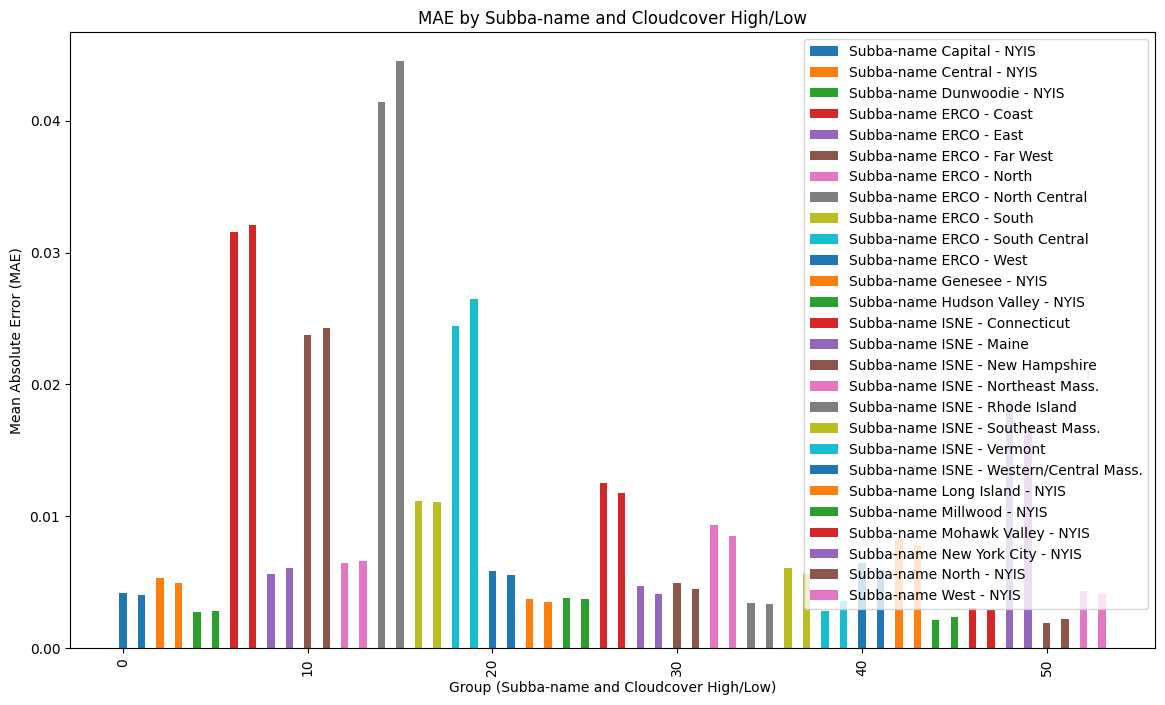

In [217]:
import matplotlib.pyplot as plt

# Reset index to prepare for plotting
metric_frame_results = metric_frame.by_group.reset_index()

# Create a bar plot of MAE by group
plt.figure(figsize=(14, 8))
for subba_name in metric_frame_results['subba-name'].unique():
    subset = metric_frame_results[metric_frame_results['subba-name'] == subba_name]
    encoder_key = 'subba-name encoder'
    label_name = label_encoders_dict[encoder_key].inverse_transform([subba_name])[0]
    
    plt.bar(subset['cloudcover_high_low'] + subba_name * 2, subset['mae'], 
            label=f'Subba-name {label_name}', width=0.4)

# Adding plot details
plt.xlabel('Group (Subba-name and Cloudcover High/Low)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Subba-name and Cloudcover High/Low')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [ ]:
# Define the overall MAE threshold (e.g., 1.5x or 2x the overall mean MAE)
threshold = 1.5 * metric_frame.overall['mae']

# Calculate absolute difference from the overall MAE for each group
metric_frame_results['mae_difference'] = abs(metric_frame_results['mae'] - metric_frame.overall['mae'])

# Identify groups with an MAE significantly above the threshold
biased_groups = metric_frame_results[metric_frame_results['mae_difference'] > threshold]
print('Overall MAE: ', metric_frame.overall['mae'])
print("Biased groups identified based on threshold:\n", biased_groups)

# Calculate ratio between highest and lowest MAE across groups
max_mae = metric_frame_results['mae'].max()
min_mae = metric_frame_results['mae'].min()
mae_ratio = max_mae / min_mae

print("MAE Ratio (max/min):", mae_ratio)


Overall MAE:  0.009466401681796233
Biased groups identified based on threshold:
     subba-name  cloudcover_high_low       mae  mae_difference
6            3                    0  0.031590        0.022124
7            3                    1  0.032111        0.022645
14           7                    0  0.041398        0.031931
15           7                    1  0.044493        0.035027
MAE Ratio (max/min): 23.753245816778758


/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/1475413278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biased_groups['subba-name'] = label_encoders_dict[encoder_key].inverse_transform(biased_groups['subba-name'])
/var/folders/65/vhl_q1tj56xd15_9mkck54dm0000gn/T/ipykernel_21437/1475413278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biased_groups['group_label'] = biased_groups.apply(lambda row: f"{row['subba-name']} (Cloudcover: {'High' if row['cloudcover_high_low'] == 1 else 

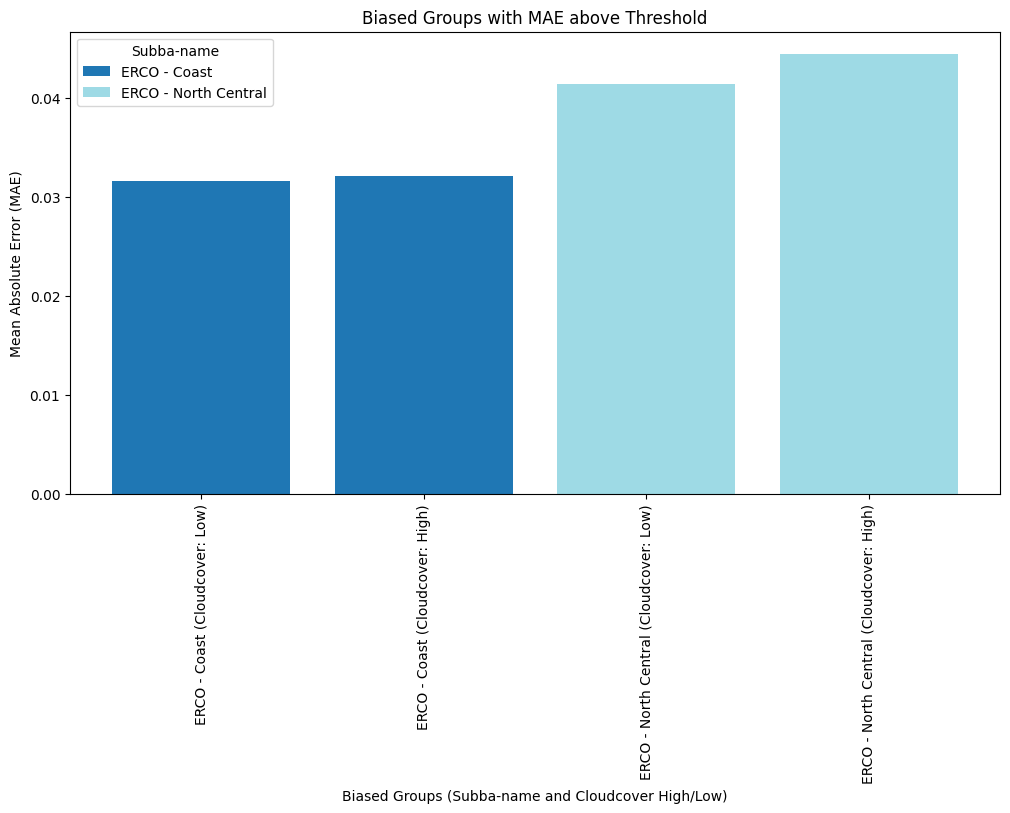

In [245]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Decode 'subba-name' with LabelEncoder's inverse_transform
encoder_key = 'subba-name encoder'
biased_groups['subba-name'] = label_encoders_dict[encoder_key].inverse_transform(biased_groups['subba-name'])

# Create a new column for the combined label of subba-name and cloudcover_high_low
biased_groups['group_label'] = biased_groups.apply(lambda row: f"{row['subba-name']} (Cloudcover: {'High' if row['cloudcover_high_low'] == 1 else 'Low'})", axis=1)

# Get unique colors for each unique subba-name
unique_subba_names = biased_groups['subba-name'].unique()
color_map = plt.cm.get_cmap('tab20', len(unique_subba_names))  # Use a colormap with enough colors

# Assign a color to each subba-name
color_dict = {subba_name: color_map(i) for i, subba_name in enumerate(unique_subba_names)}

# Plotting the bar chart with colors based on subba-name
plt.figure(figsize=(12, 6))
for index, row in biased_groups.iterrows():
    plt.bar(
        row['group_label'], row['mae'],
        color=color_dict[row['subba-name']],
        label=row['subba-name'] if row['subba-name'] not in plt.gca().get_legend_handles_labels()[1] else ""
    )

# Labeling
plt.xlabel('Biased Groups (Subba-name and Cloudcover High/Low)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Biased Groups with MAE above Threshold')
plt.xticks(rotation=90)
plt.legend(title="Subba-name")
plt.show()


In [232]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBRegressor
from fairlearn.metrics import MetricFrame

# Step 1: Define your base estimator
model = XGBRegressor(objective='reg:squarederror', random_state=42,reg_alpha=0.1, reg_lambda=1.0,learning_rate=0.05, n_estimators=1000, min_child_weight=5)


# Step 2: Calculate sample weights based on the sensitive feature
# Here, `sensitive_train` is the sensitive feature used to determine group membership for reweighting
sample_weights = compute_sample_weight(class_weight="balanced", y=sensitive_train)

# Step 3: Train the model with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights)

# Step 4: Predict on the test set
y_pred_weighted = model.predict(X_test)
metrics = {'mae': mean_absolute_error}
# Step 5: Evaluate fairness metrics by group using MetricFrame
metric_frame_weighted = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_weighted,
    sensitive_features=sensitive_test
)

print("Reweighted Model MAE by group:\n", metric_frame_weighted.by_group)
print("Overall MAE:", metric_frame_weighted.overall['mae'])



Reweighted Model MAE by group:
                                      mae
subba-name cloudcover_high_low          
0          0                    0.004194
           1                    0.004074
1          0                    0.005354
           1                    0.004972
2          0                    0.002796
           1                    0.002897
3          0                    0.031607
           1                    0.032054
4          0                    0.005663
           1                    0.006072
5          0                    0.023763
           1                    0.024249
6          0                    0.006405
           1                    0.006633
7          0                    0.041607
           1                    0.044715
8          0                    0.010947
           1                    0.011014
9          0                    0.024597
           1                    0.026629
10         0                    0.005881
           1             

In [ ]:
by_group_info = metric_frame_weighted.by_group
filtered_by_group = by_group_info.loc[by_group_info.index.get_level_values('subba-name').isin([3, 5, 7, 9])]

# filtered_rows = by_group_info[by_group_info['subba-name'].isin([3, 5, 7, 9])]
filtered_by_group

mae
subba-name cloudcover_high_low          
3          0                    0.031607
           1                    0.032054
5          0                    0.023763
           1                    0.024249
7          0                    0.041607
           1                    0.044715
9          0                    0.024597
           1                    0.026629

In [263]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor
from fairlearn.metrics import MetricFrame
from sklearn.metrics import mean_absolute_error

# Combine features and target for resampling
X_train_combined = X_train.copy()
X_train_combined['value'] = y_train
X_train_combined['sensitive_feature'] = sensitive_train  # Add sensitive feature as a column for sampling

# Step 1: Oversample underrepresented groups
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_combined, X_train_combined['sensitive_feature'])

# Separate back to features and target after resampling
y_train_resampled = X_resampled.pop('target')
sensitive_train_resampled = X_resampled.pop('sensitive_feature')

# Step 2: Train the model on the resampled data
model.fit(X_resampled, y_train_resampled)

# Step 3: Predict and evaluate
y_pred_resampled = model.predict(X_test)

# Step 4: Evaluate fairness metrics by group
metric_frame_resampled = MetricFrame(
    metrics=mean_absolute_error,
    y_true=y_test,
    y_pred=y_pred_resampled,
    sensitive_features=sensitive_test
)

print("Resampled Model MAE by group:\n", metric_frame_resampled.by_group)
print("Overall MAE:", metric_frame_resampled.overall['mean_absolute_error'])


ValueError: Cannot set a DataFrame with multiple columns to the single column sensitive_feature